# Model Analysis and Interpretation

This notebook analyzes model performance and interprets predictions.

In [4]:
import os
import sys 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from sklearn.metrics import roc_curve, precision_recall_curve
import shap

from src.utils.config import load_config
from src.utils.metrics import MetricsCalculator
sns.set_context('talk')

{"timestamp": "2025-03-10T05:00:22.286837", "level": "INFO", "name": "src.utils.config", "module": "config", "funcName": "log_config", "message": "Loaded configuration", "taskName": "Task-4", "config": "{\"data\": {\"feature_path\": \"data/processed/features/{window_size}s_window_features.parquet\", \"split\": {\"test_size\": 0.2, \"random_state\": 42, \"stratify\": true}}, \"model\": {\"type\": \"random_forest\", \"params\": {\"random_forest\": {\"n_estimators\": 200, \"min_samples_leaf\": 20, \"max_features\": \"sqrt\", \"class_weight\": \"balanced\", \"random_state\": 42}, \"gradient_boosting\": {\"n_estimators\": 200, \"learning_rate\": 0.1, \"max_depth\": 5, \"min_samples_leaf\": 10, \"random_state\": 42}, \"logistic_regression\": {\"max_iter\": 1000, \"class_weight\": \"balanced\", \"penalty\": \"l2\", \"C\": 1.0, \"random_state\": 42}, \"svm\": {\"kernel\": \"rbf\", \"C\": 1.0, \"class_weight\": \"balanced\", \"probability\": true, \"random_state\": 42}}}, \"paths\": {\"models\"

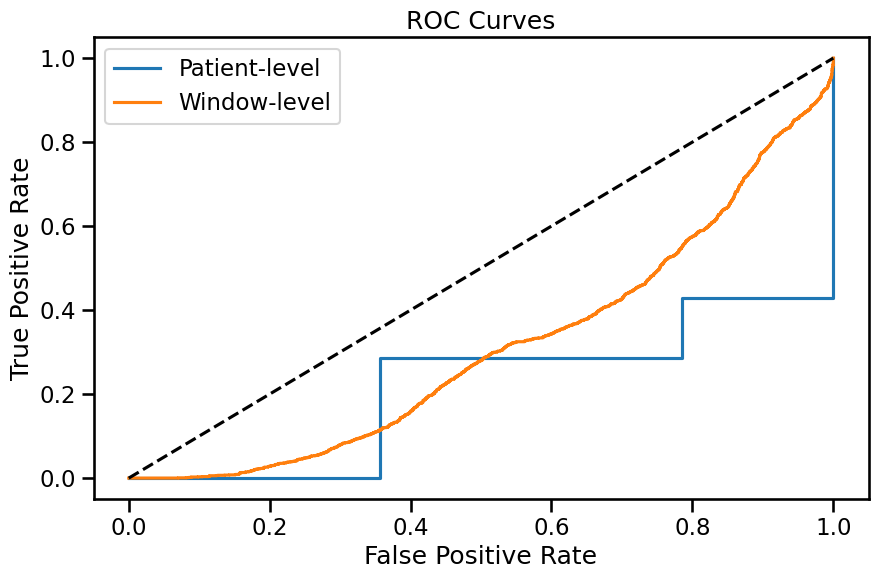

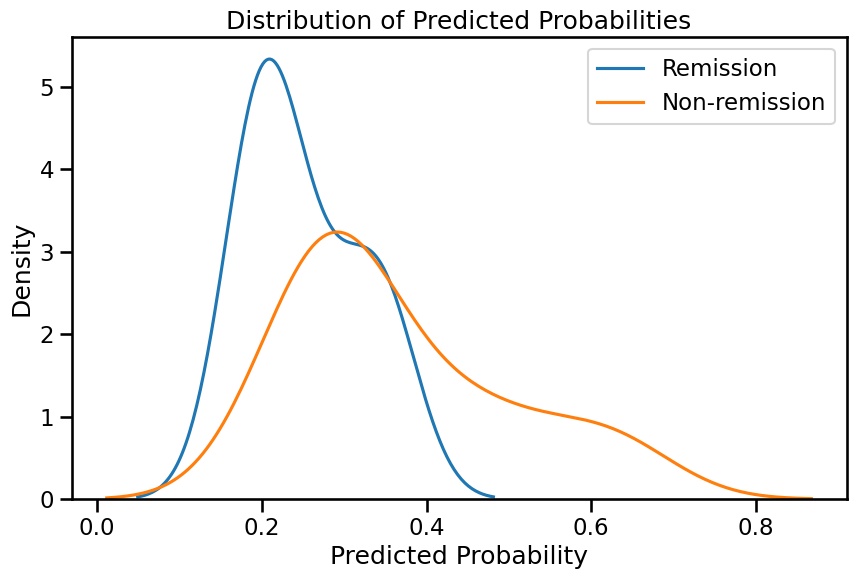

AttributeError: 'MetricsCalculator' object has no attribute 'calculate_calibration_curve'

<Figure size 1000x600 with 0 Axes>

In [16]:
# Load model and predictions
config = load_config('../../configs/window_model_config.yaml')
seconds = '2'

# Fix the path access - the correct structure based on your YAML file
model_path = Path('../../../' + config['paths']['models'])

# Load predictions
patient_predictions = pd.read_csv(model_path / (seconds + 's_window') / 'patient_predictions.csv')
window_predictions = pd.read_csv(model_path / (seconds + 's_window') / 'window_predictions.csv')

# Create metrics calculator
calculator = MetricsCalculator()

# Rest of your code remains the same...

# Calculate ROC curves
def plot_roc_curves(patient_pred, window_pred):
    plt.figure(figsize=(10, 6))
    
    # Patient-level ROC
    fpr, tpr, _ = roc_curve(patient_pred['true_label'], 
                           patient_pred['probability'])
    plt.plot(fpr, tpr, label='Patient-level')
    
    # Window-level ROC
    fpr, tpr, _ = roc_curve(window_pred['true_label'], 
                           window_pred['probability'])
    plt.plot(fpr, tpr, label='Window-level')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

plot_roc_curves(patient_predictions, window_predictions)

# Plot prediction distributions
def plot_prediction_distributions(patient_pred):
    plt.figure(figsize=(10, 6))
    
    sns.kdeplot(data=patient_pred[patient_pred['true_label'] == 1],
                x='probability',
                label='Remission')
    
    sns.kdeplot(data=patient_pred[patient_pred['true_label'] == 0],
                x='probability',
                label='Non-remission')
    
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend()
    plt.show()

plot_prediction_distributions(patient_predictions)

# Feature importance analysis
def analyze_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        sns.barplot(data=importances.head(20), x='importance', y='feature')
        plt.title('Top 20 Feature Importances')
        plt.show()
        
        return importances
    
    return None

# SHAP analysis
def analyze_shap_values(model, X, feature_names):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X, feature_names=feature_names)
    plt.show()
    
    return shap_values

# Error analysis
def analyze_errors(predictions):
    errors = predictions[predictions['true_label'] != 
                        predictions['predicted_label']]
    
    print("\nError Analysis:")
    print(f"Total errors: {len(errors)}")
    print("\nFalse Positives:")
    print(errors[errors['predicted_label'] == 1])
    print("\nFalse Negatives:")
    print(errors[errors['predicted_label'] == 0])
    
    return errors

# Calibration analysis
def plot_calibration_curve(y_true, y_prob, n_bins=10):
    plt.figure(figsize=(10, 6))
    
    fraction_of_positives, mean_predicted_value = \
        calculator.calculate_calibration_curve(y_true, y_prob, n_bins)
    
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], 'k--')
    
    plt.xlabel('Mean Predicted Value')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.show()

plot_calibration_curve(patient_predictions['true_label'],
                      patient_predictions['probability'])

# Window-to-patient analysis
def analyze_window_aggregation(window_pred):
    window_stats = window_pred.groupby('Participant').agg({
        'true_label': 'first',
        'predicted_label': ['mean', 'std'],
        'probability': ['mean', 'std', 'min', 'max']
    })
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=window_stats.reset_index(),
                    x=('probability', 'mean'),
                    y=('probability', 'std'),
                    hue='true_label')
    plt.xlabel('Mean Probability')
    plt.ylabel('Probability Std')
    plt.title('Window Prediction Variability')
    plt.show()
    
    return window_stats

window_stats = analyze_window_aggregation(window_predictions)